In [1]:
""" 
*** Functions for Tiling ***
"""
import math
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# p = (RA, DEC)
def Equi2Cart(p):
    alpha = np.radians(p[0])
    delta = np.radians(p[1])
    x = np.cos(alpha) * np.cos(delta)
    y = np.sin(alpha) * np.cos(delta)
    z = np.sin(delta)
    return [x, y, z]
    # returns a vector in cartesian

# v = [x, y, z]
def Cart2Equi(v):
    x, y, z = v[0], v[1], v[2]
    ra = np.rad2deg(math.atan2(y,x))
    dec = np.rad2deg(math.asin(z))
    return [ra, dec]
    # returns a point in equitorial

# rotate about tile center
def rotate(angle):
    theta = np.radians(angle)
    Rx = [[1, 0, 0],
          [0, np.cos(theta), -np.sin(theta)],
          [0, np.sin(theta), np.cos(theta)]]
    return Rx

# move the center of the tile to the desired equatorial coordinates
def move(RA, DEC):
    alpha = np.radians(RA)
    delta = np.radians(DEC)
    # move to DEC coordinate
    Ry = [[np.cos(delta), 0, -np.sin(delta)],
          [0, 1, 0],
          [np.sin(delta), 0, np.cos(delta)]]
    # move to RA coordinate
    Rz = [[np.cos(alpha), -np.sin(alpha), 0],
          [np.sin(alpha), np.cos(alpha), 0],
          [0, 0, 1]]
    return np.matmul(Rz, Ry)

# coordinates of each CCD of the tile = [CCD1, CCD2, CCD3, CCD4]
def CCD_array(l=900/3600, w=860/3600, g=26/3600):
    RA = {1: g/2 + l, 2: g/2 + l, 3: g/2, 4: g/2, 5: g/2 + l, 6: g/2 + l, 7: g/2, 8: g/2, 
          9: -g/2, 10: -g/2, 11: -(g/2 + l), 12: -(g/2 + l), 13: -g/2, 14: -g/2, 15: -(g/2 + l), 16: -(g/2 + l)}
    DEC = {1: -(g/2 + w), 2: -g/2, 3: -g/2, 4: -(g/2 + w), 5: g/2, 6: g/2 + w, 7: g/2 + w, 8: g/2,
           9: g/2, 10: g/2 + w, 11: g/2 + w, 12: g/2, 13: -(g/2 + w), 14: -g/2, 15: -g/2, 16: -(g/2 + w)}
    tile = [[] for _ in range(4)]
    for i in range(1, 17):
        tile[(i - 1) // 4].append(Equi2Cart((RA[i],DEC[i])))
    return tile

# the projected length at a given declination 
def ProjDec(length, DEC):
    p = [length, 0]
    pp = Cart2Equi(np.matmul(move(0, DEC), Equi2Cart(p)))
    return pp[0]

# returns the intersection ratio between the tile and footprint
def per_tile(footprint, RA, DEC, angle=0, l=900/3600, w=860/3600, g=26/3600):
    CCDs = []
    tile = CCD_array(l, w, g)
    inter_area = 0
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(angle), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        # create polygon for each CCD in the CCD_array
        vertices = [(x, y) for x, y in zip(ra, dec)]
        polygon = Polygon(vertices)
        # each CCD's intersection with the footprint
        CCD_footprint = polygon.intersection(footprint)
        inter_area += CCD_footprint.area
        CCDs.append(polygon)
    # each tile is a multipolygon
    mp = MultiPolygon(CCDs)
    tile_area = mp.area  # each tile's area
    intersect_ratio = inter_area / tile_area
    return intersect_ratio

### Tiling Strategy: Up-Down Vertical Bin Tiling

In [2]:
""" 
*** Organize the tiles in each RA bins from least to most polar tiles ***
"""
def BinTiling(coords, min_intersect_ratio, tile_overlap=30/3600, l=900/3600, w=860/3600, g=26/3600):
    
    # Footprint boundary
    footprint = Polygon(coords)
    xmin, ymin, xmax, ymax = footprint.bounds
    # Avoid computing tiles at the [-180, 180] boundary
    if xmin < -179.9:
        xmin = -179.9
    if xmax > 179.9:
        xmax = 179.9
    
    # Collect valid tile center coords in tiling sequence
    tile_centers = [] 
    valid = []
    RAvals = []
    max_length = 0 
    
    slew_length = (2*l + g) - tile_overlap
    slew_width = (2*w + g) - tile_overlap
    DECvals = np.arange(ymin+w, ymax+w, step=slew_width)
    
    # Calculate the RAs for a given DEC and find valid tiles
    for DEC in DECvals:
        RArow = np.arange(xmin + ProjDec(l, DEC), xmax + ProjDec(l, DEC), step=ProjDec(slew_length, DEC))
        max_length = max(max_length, len(RArow))
        for RA in RArow:
            intersect_ratio = per_tile(footprint, RA, DEC)
            if intersect_ratio >= min_intersect_ratio:
                    valid.append((RA, DEC))
    
    # Create RA bins
    """ Can make bin_size a parameter """ 
    # currently set it as the length of the CASTOR tile
    bin_size = ProjDec(slew_length, max(DECvals, key=abs))
    bin_intervals = []
    start = xmin
    while start < xmax:
        end = start + bin_size
        bin_intervals.append((start, end))
        start = end
    
    # Sort valid tiles into their respective RA bins
    RAbins = {interval: [] for interval in bin_intervals}
    for RA, DEC in valid:
        for interval in bin_intervals:
             if interval[0] <= RA < interval[1]:
                 RAbins[interval].append((RA, DEC))
                 break
    
    # Sort each RA bin from least to greatest DEC values
    # tile_centers = [ [RA bin tuple coords], [(RA,DEC), (...), ...] ]
    for interval, tiles in RAbins.items():
        RAbins[interval] = sorted(tiles, key=lambda coord:-coord[1])
        tile_centers.append(RAbins[interval])

    return tile_centers

In [3]:
"""
*** Functions for tracking time and calculating observing efficiency ***
"""
import math 

# Find the angle (in degrees) between two points in equatorial coordinates (in deg)
def Haversine(p1, p2):
    ra1, dec1 = np.radians(p1[0]), np.radians(p1[1])
    ra2, dec2 = np.radians(p2[0]), np.radians(p2[1])
    theta12 = 2 * np.arcsin(np.sqrt(np.sin((dec2-dec1)/2)**2 + np.cos(dec1)*np.cos(dec2)*np.sin((ra2-ra1)/2)**2))
    return np.rad2deg(theta12)

def Angle2Time(theta):
    # Paul's Slew Angle vs. Slew Duration data
    slew_angle = np.array([0, 0.5, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 90, 90])
    slew_duration = np.array([30, 30, 66, 102, 138, 168, 198, 240, 276, 306, 336, 366, 414, 468])
    # linear interpolation --> interpolate slew time given the slew angle
    slew_time = np.interp(theta, slew_angle, slew_duration)
    return slew_time

def Seconds2Day(time):
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    return day, hour, minutes, seconds

# Convert time elapsed in an orbit (sec.) --> telescope's position (degrees) in an orbit around the Earth
# Angle theta starts in the East (viewed facing sun) going CCW; always between 0° to 360°
def Position(orbitTimeTrack):
    period = 100.9 # min
    # orbitTimeTrack is time elapsed from startAngle 
    theta = (orbitTimeTrack/60/period)*360 # degrees
    return theta

# the time passed (in sec.) while the telescope moves a given angle in the orbit
def PassedTime(angle):
    period = 100.9 # min
    return (angle/360)*period*60
    
# Viewing angle as a function of theta_b (in deg)
# theta_b: boresight angle as measured from CVZ center (angle away from CVZ center)
def ViewingFrac(theta_b):
    # Earth radius
    Re = 6378*1000 # m
    # satellite orbit altitude
    h = 800*1000 # m
    # Earth limb angle
    rho = math.degrees(math.asin(Re/(Re+h))) # deg
    # Earth exclusion angle
    epsilon = 10 # deg    
    # nu: satellite orbit position angle, measured from the X-axis
    # delta_nu: viewing angle (rad); symmetrical about the Y-axis
    if 0 <= theta_b <= 90-rho-epsilon:
        frac = 1
    else:
        delta_nu = math.pi + 2*math.asin(math.cos(math.radians(rho+epsilon)) / math.sin(math.radians(theta_b)))
        frac = math.degrees(delta_nu) / 360
    return frac

# With theta = 0° at positive RA (x-axis) direciton, (i.e. starts in the East viewed facing sun) going CCW
# satellite position = (x0, y0) where y0 = -7.8
# target = tile_center coords (x, y)
def ViewingZone(x0, target):
    y0 = -7.8
    x, y = target[0], target[1]
    xp = x - x0
    yp = y - y0
    # the direction where the boresight is pointing 
    theta = math.degrees(math.atan2(yp, xp))
    theta = (theta + 360) % 360
    # the angular distance the pointing is away from CVZ
    theta_b = math.sqrt(xp**2 + yp**2)
    #print('angle away from CVZ center:', theta_b)
    frac = ViewingFrac(theta_b)
    #print('viewing efficiency:', frac)
    halfVisAngle = frac*180 # degrees
    zone = [(theta-halfVisAngle+360)%360, (theta+halfVisAngle+360)%360]
    return zone

# Determine the types of viewing zone
def ZoneType(index, startzone, endzone):
    # three types of viewing zone
    if endzone-startzone > 10**-5:
        # the viewing zone is continuous, where startzone < endzone
        type = 1
        #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    elif round(startzone,5) == round(endzone,5):
        # the tile is in CVZ
        type = 2
        #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, {round(endzone,4)}°] \033[0m")
    else:
        # the viewing zone wraps around from 360° to 0° 
        type = 3
        #print(f"\033[1mtile {index}'s viewing zone: [{round(startzone,4)}°, 360°] [0°, {round(endzone,4)}°] \033[0m")
    return type

def AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime):
    if startzone > theta:
        dead_time = PassedTime(startzone-theta+0.0001)
    else:
        dead_time = PassedTime(360-theta+startzone+0.0001)
    place_holder.append([dead_time, [theta, startzone+0.0001]])
    ElapsedTime += dead_time
    dayTimeTrack += dead_time
    weekTimeTrack += dead_time
    orbitTimeTrack += dead_time
    dataTimeTrack += dead_time
    DeadTime += dead_time
    #print('Dead time:', round(dead_time,2), 's')
    #print()
    return place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime

# Calculate how much time is available in the current viewing cycle
def TimeAvailable(type, endzone, theta): 
    if type==1:
        time_available = PassedTime(endzone-theta)
    elif type==2:
        time_available = PassedTime(360) # if the tile is in CVZ, there is infinite time available
    else:
        if endzone > theta:
            time_available = PassedTime(endzone-theta)
        else:
            time_available = PassedTime(360-theta+endzone)
    return time_available

# Update the time spend on moving to the tile and imaging
# need to specify which of the actions(slew, settle, and exposure) are included in this update
def Update4Imaging(slew, settle, Exposure, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack):
    slew_time += slew
    settle_time += settle
    exposure_time += Exposure
    SurveyTime += Exposure + slew + settle
    ElapsedTime += Exposure + slew + settle
    dayTimeTrack += Exposure + slew + settle
    weekTimeTrack += Exposure + slew + settle
    orbitTimeTrack += Exposure + slew + settle
    dataTimeTrack += Exposure + slew + settle
    return slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack

""" Time Trackers in the WideObserving code """
# Track Data
def TrackData(dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data):
    # Data Info
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    data_parts = data/4
    downlink_rate = 10/8 # GBps
    # max downlink window
    downlink_window = 5*60 # seconds
    downlink_max = downlink_rate * downlink_window # GB
    datacap = 440 # GB
    
    if dataTimeTrack >= 12*3600:
        #print('... Downlinking Data ...')
        #print()
        data_capacity = round((onboard_data/datacap)*100, 1)
        # data >= 375 GB
        if onboard_data >= downlink_max:
            downlink_time += downlink_window + 1*60
            SurveyTime += downlink_window + 1*60
            ElapsedTime += downlink_window + 1*60
            dayTimeTrack += downlink_window + 1*60
            weekTimeTrack += downlink_window + 1*60
            downlinked_data += downlink_max
            onboard_data -= downlink_max
        # data < 375 GB
        else:
            downlink_time += (onboard_data/downlink_rate) + 1*60
            SurveyTime += (onboard_data/downlink_rate) + 1*60
            ElapsedTime += (onboard_data/downlink_rate) + 1*60
            dayTimeTrack += (onboard_data/downlink_rate) + 1*60
            weekTimeTrack += (onboard_data/downlink_rate) + 1*60
            downlinked_data += onboard_data
            onboard_data = 0
        dataTimeTrack = 0 
    return dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data

# Track Orbit around Earth
def TrackOrbit(orbitTimeTrack, orbit_num):
    period = 100.9 # min
    # onto the the next orbit
    if orbitTimeTrack >= period*60:
        orbit_num += 1
        #print(f'{round(orbitTimeTrack/60,2)} min. passed --> entering new orbit')
        #print()
        orbitTimeTrack -= period*60
    return orbitTimeTrack, orbit_num

# Track Day: update satellite position across RA every day
def TrackDay(dayTimeTrack, day_num, sat_position):
    daily_step = 360/365 # CVZ center movement across RA per day
    if dayTimeTrack >= 24*60*60:
        day_num += 1
        sat_position += daily_step
        # print()
        # print(f'\033[1m{round(dayTimeTrack/60/60,2)} hrs passed --> a new day\033[0m')
        # print(f"\033[1msatellite's RA = {sat_position}°\033[0m")
        # print()
        dayTimeTrack = 0
    return dayTimeTrack, day_num, sat_position

# Track Week: document information after every week
def TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week):
    if weekTimeTrack >= 604800:
        week_num += 1
        #print(f'{round(weekTimeTrack/60/60/24,2)} days passed --> a new week')
        #print()
        week[week_num] = tiles_per_week
        tiles_per_week = []
        if open_per_week == []:
            open_per_week.append(exposure_time)
            overhead_per_week.append(SurveyTime-exposure_time)
            dead_per_week.append(DeadTime)
        else:
            open_per_week.append(exposure_time - sum(open_per_week))
            overhead_per_week.append((SurveyTime - exposure_time) - sum(overhead_per_week))
            dead_per_week.append(DeadTime - sum(dead_per_week))
        weekTimeTrack -= 604800
    return weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week


### WideObserving
Applies to wide surveys that require binning tiles into columns, each column has the same width of that of the most polar tile in the survey. 

In [4]:
def WideObserving(coords, days_ahead, startAngle, exposure, settle=90):
    
    tile_sequence = [] # a list of tile coordinates in their imaging order
    # track the slewing sequence
    slew_sequence = [] # a list of tile polarity in their imaging order
    
    # place_holder = [dead_time (s), telescope position range] 
    place_holder = [] # telescope position range = [start (deg), end (deg)]
    
    """ Imaging Requirement """
    # sub-exposures of 250s 
    exposure_parts = exposure/4 # seconds
    px_amount = 8600 * 9000 * 4 * 3 # pixels
    byte_per_px = 2 # bytes
    data = (px_amount * byte_per_px)/10**9 # GB
    data_parts = data/4 
    
    # all time are in seconds if not specified
    """ Time Tracker """
    dayTimeTrack = 0
    weekTimeTrack = 0
    orbitTimeTrack = 0
    dataTimeTrack = 0 
    DeadTime = 0
    SurveyTime = 0
    ElapsedTime = 0
    
    """ Info Tracker """
    slew_time = 0
    settle_time = 0
    exposure_time = 0
    downlink_time = 0 
    onboard_data = 0 # GB
    downlinked_data = 0 # GB
    orbit_num = 0
    day_num = 0
    week_num = 0
    # a list of time required to complete each bin
    time_per_bin = []
    # a list of tile coords in their imaging order in the week
    tiles_per_week = []
    # a list of open-shutter time accumulated per week
    open_per_week = [] 
    # a list of overheads accumulated per week 
    overhead_per_week = []
    # a list of deadtimes accumulated per week
    dead_per_week = [] 
    # a dictionary with key: week_num, value: tiles_per_week
    week = {} 

    # Determine all the tile coordinates in the survey
    tile_centers = BinTiling(coords, min_intersect_ratio=0.3)
    tile_num = len([tile for bins in tile_centers for tile in bins])
    index = 1
    #print(f'should expect {tile_num} tiles')
    #print(f'in {len(tile_centers)} RA bins')

    """ Satellite Position """
    # start the satellite's RA position "days_ahead" the left-most column of the survey
    daily_step = 360/365 # CVZ center movement across RA per day
    sat_position = tile_centers[0][0][0] - days_ahead*daily_step
    
    remain = [] # stores tiles with remaining exposures in imaging order
    remain_vals = [] # stores the remaining exposures of each tile in imaging order 
    exposure_remain = 0
    scenario = 0 # indicator for the three scenarios when imaging less polar tiles

    """ BEGIN OBSERVING HERE: going through all the tiles in this survey """
    for n, bins in enumerate(tile_centers):
        # For each RA bin, label the tiles from least to most polar 
        label = list(range(1, len(bins)+1))
        # show the RA position of the satellite at the beginning of imaging each bin
        print(f"for bin{n+1}, satellite's current RA = {sat_position}")
        print(f"the tiles are on RA ~ {bins[0][0]}")
        print()
        # apply this loop if either the bin or the remain is non-empty
        while bins or remain:
            if bins != []:
                theta = (Position(orbitTimeTrack) + startAngle) % 360
                #print(f'telescope position around Earth = {round(theta,4)}°')
                
                """ Select a tile """
                # at Norther Hemisphere, pick less polar tiles to image
                # or if the least polar tile is in CVZ (see "Not enough time")
                if (0 <= theta <= 180) or (CVZ == True):
                    polar = 0 # less polar indicator
                    tile = bins.pop(0)
                    label_val = label.pop(0)
                    CVZ = False # set this CVZ indicator back to False after the tile has been acquired 
                # at Southern Hemisphere, pick more polar tiles to image
                else:
                    polar = 1 # more polar indicator
                    tile = bins.pop()
                    label_val = label.pop()
               
                # Find the tile's viewing zone based on the satellite RA position 
                zone = ViewingZone(sat_position, tile)
                startzone, endzone = zone[0], zone[1]
                type = ZoneType(index, startzone, endzone)
                    
                # When the telescope is NOT in the selected tile's viewing zone, WAIT until it is in the zone
                if not((type==1 and startzone<=theta<=endzone) or type==2 or (type==3 and (startzone<=theta<=360 or 0<=theta<=endzone))):
                    """ Add dead time """
                    place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                    theta = (Position(orbitTimeTrack) + startAngle) % 360
                    #print(f'telescope position around Earth = {round(theta,4)}°')
                
                """ Track Orbit """
                orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                """ Track Day """
                dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                """ Track Week """
                weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

                # When the telescope IS in the selected tile's viewing zone, allow imaging
                # But first, check if there's enough time left to complete at least one exposure segment 
                time_available = TimeAvailable(type, endzone, theta)
                time_used = 0
                if index != 1:
                    angle = Haversine(tile_sequence[-1], tile)
                    slew = Angle2Time(angle)
                    time_used = slew + settle
                time_left = time_available - time_used
        
                # Not enough time
                if time_left < exposure_parts:
                    #print(f'time available for imaging in this orbit: {round(time_left,4)}s, NOT enough time')
                    if polar == 1:
                        bins.append(tile)
                        label.append(label_val)
                        # make sure to add dead time to enter the "least polar" tile's viewing zone
                        tile = bins[0]
                        zone = ViewingZone(sat_position, tile)
                        startzone, endzone = zone[0], zone[1]
                        type = ZoneType(index, startzone, endzone)
                        # don't add deadtime if the least polar tile is in CVZ
                        if type == 2:
                            CVZ = True
                            continue # go straight to the next "while loop" iteration
                    else:
                        bins = [tile] + bins    
                        label = [label_val] + label
                    """ Add dead time """
                    place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                    continue # go straight to the next "while loop" iteration
                # Enough time
                else:
                    # Slew to the tile
                    if index != 1:
                        #print('slew + settle takes', slew + settle, 's')
                        """ Update Time - moving to the tile """
                        slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, 0, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                        
                    #print(f'time available for imaging in this orbit: {round(time_left,4)}s, enough to complete at least one exposure segment')
                    #print()
                    tile_sequence.append(tile)
                    tiles_per_week.append(tile)
                    slew_sequence.append(label_val)
                    #print(f'\033[1mtile {index}: {label_val}\033[0m')
                    
                    # Determine how many of the segmented exposures can be completed
                    #print('*** IMAGING ***')
                    Exposure = 0
                    while Exposure < exposure and exposure_parts < time_left :
                        Exposure += exposure_parts
                        #print('exposure =', Exposure, 's')
                        time_left -= exposure_parts
                        #print('time left =', round(time_left,2), 's')
                        onboard_data += data_parts
                    #print('Exposure =', Exposure, 's')
            
                    # Determines if there are remaining exposures
                    if Exposure == exposure:
                        exposure_remain = 0
                        #print(f'<< tile {index} COMPLETED >>')
                        # the index for the next tile
                        index += 1
                        #print('going to tile', index)
                        #print()
                    else:
                        exposure_remain = exposure - Exposure
                        #print('Remaining exposure =', exposure_remain, 's')
                        #print()
                        remain.append(tile)
                        remain_vals.append(exposure_remain)
                        rlabel = label_val
        
                    """ Update Time - imaging tile """
                    slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, Exposure, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                
                """ Track Data """
                dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data = TrackData(dataTimeTrack, downlink_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, downlinked_data, onboard_data)
                """ Track Orbit """
                orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                """ Track Day """
                dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                """ Track Week """
                weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)
                    
            """ --------------------------------------------------------------------------------------------------------- """
            # For the tile with remaining exposures
            if remain != []:
                # Update telescope position
                theta = (Position(orbitTimeTrack) + startAngle) % 360
                #print(f'telescope position around Earth = {round(theta,4)}°')
                
                # If the tile with remaining exposure is less polar, or if there is no other tile in the bin,
                # continue imaging, because no other tile in the bin is going to have better viewing efficiency
                # the viewing zone will be of the same tile 
                if polar == 0 or bins == []: 
                    #print('remaining tile - continue imaging, because it is the least polar')
                    tile = remain.pop()
                    
                    # Add dead time so the telescope is in a new viewing cycle
                    """ Add dead time """
                    place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                    """ Track Orbit """
                    orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                    """ Track Day """
                    dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                    """ Track Week """
                    weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

                    # Update telescope position
                    theta = (Position(orbitTimeTrack) + startAngle) % 360
                    #print(f'telescope position around Earth = {round(theta,4)}°')
    
                    # Complete the remaining exposure
                    exposure_remain = remain_vals.pop()
                    
                    # the telescope should be in the viewing zone
                    if (type==1 and startzone<=theta<=endzone) or type==2 or (type==3 and (startzone<=theta<=360 or 0<=theta<=endzone)):
                        # available viewing time
                        time_available = TimeAvailable(type, endzone, theta)
                        #print('time available for imaging in this orbit:', round(time_available,4), 's')
                        # Expecting to be able to complete the remaining exposures
                        if exposure_remain <= time_available:
                            Exposure = 0
                            while exposure_remain != 0:
                                Exposure += exposure_parts
                                exposure_remain -= exposure_parts
                                onboard_data += data_parts
                            #print(f'remaining exposure of {Exposure}s COMPLETED')
                            #print(f'<< tile {index} COMPLETED >>')
                            # the index for the next tile
                            index += 1
                            #print('going to tile', index)
                            #print()
                        else:
                            print('!!! SOMETHING IS WRONG !!!')
                            print('cannot finish the remainings')
                            break
                        """ Update Time - imaging tile """
                        slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, Exposure, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                    else:
                        print('!!! SOMETHING IS WRONG !!!')
                        print('the telescope is not in the viewing zone')
                        break
    
                    """ Track Orbit """
                    orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                    """ Track Day """
                    dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                    """ Track Week """
                    weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

                # If the tile with remaining exposure is more polar, select a less polar tile first 
                else:
                    #print('remaining tile - more polar, will image a less polar tile first')
                    # Store the previous remaining tile's viewing zone info
                    rstartzone, rendzone, rtype = startzone, endzone, type
                    
                    # determine the remainging view time of the remaining tile
                    # (rview is an indicator of what scenario it is)
                    if rtype == 1:
                        rview = 1
                    else:
                        if theta > rstartzone:
                            rview = 3.1
                        else:
                            rview = 3.2
                    end = theta-0.0001
                    
                    # Fully image other less polar tiles until the telescope is back in the remaining tile's viewing zone
                    count = 0 # count how many tiles are imaged before going back to the previous tile

                    while not (((rview==1 or rview==3.1) and rstartzone<=theta<=end) or (rview==3.2 and (rstartzone<=theta<=360 or 0<=theta<=end))):
                        """ Track Orbit """
                        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                        """ Track Day """
                        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                        """ Track Week """
                        weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

                        # the index of this next tile
                        index += 1
                        #print('going to tile', index)
                        #print()
                        
                        # Update telescope position
                        theta = (Position(orbitTimeTrack) + startAngle) % 360
                        #print(f'telescope position around Earth = {round(theta,4)}°')
                        
                        # Select the tile and determine its viewing zone
                        polar = 0 # less polar indicator
                        tile = bins.pop(0)
                        label_val = label.pop(0)
                        zone = ViewingZone(sat_position, tile)
                        startzone, endzone = zone[0], zone[1]
                        type = ZoneType(index, startzone, endzone)
                
                        """
                        three possible scenarios 
                        (1) outside of viewing zone
                        (2) inside viewing zone but time left < 250s
                        (3) inside viewing zone and time left > 250s
                        """
                        # scenario (1): wait until the next orbit to image
                        if not((type==1 and startzone<=theta<=endzone) or type==2 or (type==3 and (startzone<=theta<=360 or 0<=theta<=endzone))):
                            scenario = 1
                            #print('scenario (1): outside of viewing zone')
                            # Add dead time so the telescope is in a new viewing cycle
                            """ Add dead time """
                            place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                            """ Can complete the tile uninterrupted """
                            
                        # scenario (2) & (3): if telescope is in selected (less polar) tile's viewing zone 
                        else: 
                            # Find how much time is left in this orbit
                            theta = (Position(orbitTimeTrack) + startAngle) % 360
                            time_available = TimeAvailable(type, endzone, theta)
                            time_used = 0
                            angle = Haversine(tile_sequence[-1], tile)
                            slew = Angle2Time(angle)
                            time_used = slew + settle
                            time_left = time_available - time_used
    
                            # scenario (2): inside viewing zone BUT not enough time to image
                            if time_left <= exposure_parts:
                                #print(f'time available for imaging in this orbit: {round(time_left,4)}s')
                                scenario = 2
                                #print('scenario (2): inside viewing zone BUT not enough time to image')
                                """ Add dead time """
                                place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                                """ Track Orbit """
                                orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                                """ Track Day """
                                dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                                """ Track Week """
                                weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)
                                """ Can complete the tile uninterrupted """
                                
                            # scenario (3): inside viewing zone AND enough time to image at least one exposure segment
                            else:
                                scenario = 3
                                #print('scenario (3): inside viewing zone AND will image')
                                #print('slew + settle takes', slew + settle, 's')
                                #print(f'time available for imaging in this orbit: {round(time_left,4)}s')
                                #print()
                                tile_sequence.append(tile)
                                tiles_per_week.append(tile)
                                slew_sequence.append(label_val)
                                #print(f'\033[1mtile {index}: {label_val}\033[0m')
                        
                                # Determine how many of the segmented exposures can be completed
                                #print('*** IMAGING ***')
                                Exposure = 0
                                while Exposure < exposure and exposure_parts < time_left :
                                    Exposure += exposure_parts
                                    #print('exposure =', Exposure, 's')
                                    time_left -= exposure_parts
                                    #print('time left =', round(time_left,2), 's')
                                    onboard_data += data_parts
                                #print('Exposure =', Exposure, 's')
                                
                                """ Update Time - moving to the tile and imaging """
                                slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, Exposure, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)    
                                # Update telescope position
                                theta = (Position(orbitTimeTrack) + startAngle) % 360      
                                #print(f'telescope position around Earth = {round(theta,4)}°')
                                
                                exposure_remain = exposure - Exposure
                                
                                # If there are remainings, it'll be imaged immediately after dead time
                                if exposure_remain != 0:
                                    #print('Remaining exposure =', exposure_remain, 's')
                                    remain_vals.append(exposure_remain)
                                    """ Add dead time """
                                    place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime = AddDeadTime(startzone, theta, place_holder, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack, DeadTime)
                                    """ Can complete the tile uninterrupted """
                                    
                                # If the less polar tile is completed, the code will enter a new iteration of the 'while' loop
                                else:
                                    #print('Remaining exposure =', exposure_remain, 's')
                                    #print(f'<< tile {index} COMPLETED >>')
                                    count += 1 # the tile is completed
                                    theta = (Position(orbitTimeTrack) + startAngle) % 360
                                    continue
                                    
                        """ Track Orbit """
                        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                        """ Track Day """
                        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                        """ Track Week """
                        weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

                        # Update telescope position
                        theta = (Position(orbitTimeTrack) + startAngle) % 360
                        #print(f'telescope position around Earth = {round(theta,4)}°')
    
                        """ Can complete the tile uninterrupted """
                        # For scenario (3), only partial exposures remain; hence there are multiple remaining tiles
                        if len(remain_vals) > 1:
                            #print(f'complete tile {index} from scenario (3)')
                            exposure_remain = remain_vals.pop()
                            Exposure = 0
                            while Exposure < exposure_remain:
                                Exposure += exposure_parts
                                onboard_data += data_parts
                        # For scenario (1) and (2), there's only one remaining tile, since newly selected tile hasn't been imaged
                        else: 
                            tile_sequence.append(tile)
                            tiles_per_week.append(tile)
                            slew_sequence.append(label_val)
                            #print(f'\033[1mtile {index}: {label_val}\033[0m')
                            # Slew to the tile
                            angle = Haversine(tile_sequence[-2], tile_sequence[-1])
                            slew = Angle2Time(angle)
                            #print('slew + settle takes', slew + settle, 's')
                            """ Update Time - moving to the tile """
                            slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, 0, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                            # "Fully" image the tile
                            Exposure = exposure
                            onboard_data += data
                        count += 1 # the tile is completed
                        #print(f'<< tile {index} COMPLETED >>')
                        #print('Exposure =', Exposure, 's')
                        """ Update Time - imaging tile """
                        slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(0, 0, Exposure, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                     
                        # indicator reverts back to zero after the tile is completed
                        scenario = 0

                        """ Track Orbit """
                        orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                        """ Track Day """
                        dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                        """ Track Week """
                        weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)

                        # Update telescope position
                        theta = (Position(orbitTimeTrack) + startAngle) % 360
                        
                        # Check if the while loop will continue running
                        if not ((type==1 and rstartzone<=theta<=rendzone) or (type==3 and (rstartzone<=theta<=360 or 0<=theta<=rendzone))):
                            #print(f'telescope position around Earth = {round(theta,4)}°')
                            #print('Another tile will be imaged before slewing back to the previous remaining tile')
                            pass

                    
                    #print()
                    # Update telescope position
                    theta = (Position(orbitTimeTrack) + startAngle) % 360
                    #print(f'telescope position around Earth = {round(theta,4)}°')
    
                    # Available viewing time for the original remaining tile
                    time_available = TimeAvailable(rtype, rendzone, theta)
                    #print('time available for imaging in this orbit:', round(time_available,4), 's')
                    
                    # Slew back to the original remaining tile
                    tile = remain.pop()
                    tile_sequence.append(tile)
                    tiles_per_week.append(tile)
                    slew_sequence.append(rlabel)
                    #print(f'\033[1mtile {index-count}: {rlabel}\033[0m')
                    angle = Haversine(tile_sequence[-(count+1)], tile_sequence[-1])
                    slew = Angle2Time(angle)
                    #print(f'\033[1mslewing back to tile {index-count} \033[0m')
                    #print('slew + settle takes', slew + settle, 's')
    
                    # Complete the remaining exposures
                    Exposure = 0
                    exposure_remain = remain_vals.pop()
                    while exposure_remain != 0:
                        Exposure += exposure_parts
                        exposure_remain -= exposure_parts
                        onboard_data += data_parts
                    #print(f'remaining exposure of {Exposure}s COMPLETED')
                    #print(f'<< tile {index-count} COMPLETED >>')

                    """ Update Time - moving to the tile and imaging """
                    slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack = Update4Imaging(slew, settle, Exposure, slew_time, settle_time, exposure_time, SurveyTime, ElapsedTime, dayTimeTrack, weekTimeTrack, orbitTimeTrack, dataTimeTrack)
                
                    # the index for the next tile
                    index += 1
                    #print('going to tile', index)
                    #print()
                    
                    """ Track Orbit """
                    orbitTimeTrack, orbit_num = TrackOrbit(orbitTimeTrack, orbit_num)
                    """ Track Day """
                    dayTimeTrack, day_num, sat_position = TrackDay(dayTimeTrack, day_num, sat_position)
                    """ Track Week """
                    weekTimeTrack, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week = TrackWeek(weekTimeTrack, exposure_time, SurveyTime, DeadTime, week_num, week, tiles_per_week, open_per_week, overhead_per_week, dead_per_week)       
              
        # When all tiles in the bin is imaged
        if time_per_bin == []:
            time_per_bin.append(ElapsedTime)
        else:
            time_per_bin.append(ElapsedTime - sum(time_per_bin))
        
    # When all tiles are completed
    index -= 1
    #print('slew sequence: ', slew_sequence)
    print(f'{index} tiles imaged')
    print('currently on orbit', orbit_num+1)
    #print()
    
    # From the last incomplete week / orbit
    week[week_num+1] = tiles_per_week
    open_per_week.append(exposure_time - sum(open_per_week))
    overhead_per_week.append((SurveyTime - exposure_time) - sum(overhead_per_week))
    dead_per_week.append(DeadTime - sum(dead_per_week))

    print(f'* exposure time: {int(exposure_time)}s = {round(exposure_time/3600,2)} hrs') 
    Overheads = slew_time + settle_time + downlink_time
    print('* overheads (slew + settle + downlink data):')
    print(f'   {round(Overheads/3600,2)} hrs')
    TotalDeadTime = ElapsedTime - SurveyTime
    print(f'\033[1m* Total dead time: {round(TotalDeadTime/3600,2)} hrs\033[0m')
    print()
    print('\033[1mSurvey Time = exposure + overheads\033[0m')
    time = Seconds2Day(SurveyTime)
    print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec \033[0m')
    print('\033[1mTotal Elapsed Time = survey + deadtime\033[0m')
    time = Seconds2Day(ElapsedTime)
    print(f'{time[0]} day, {time[1]} hr, {time[2]} min, {time[3]} sec \033[0m')
    # print('\033[1mTotal time elapsed (hrs) per bin:\033[0m')
    # print((np.array(time_per_bin)/3600).round(2))
    Efficiency = (exposure_time / ElapsedTime)*100
    MaxEfficiency = (exposure_time + TotalDeadTime/3) / ElapsedTime * 100
    print(f'\033[1mObserving Efficiency: {round(Efficiency,2)}%\033[0m')
    print(f'Assume we can \033[1mrecover one third of the deadtime\033[0m') 
    print(f'the observing efficiency is: \033[1m{round(MaxEfficiency,2)}%\033[0m')
    print()
    print(f'Data onboard: {round(onboard_data,2)} GB')
    print(f'Data downlinked: {round(downlinked_data,2)} GB')

    return tile_sequence, slew_sequence, place_holder, time_per_bin, open_per_week, overhead_per_week, dead_per_week, week, Efficiency


In [5]:
# Wide Survey footprint boundary coordinates
coords = np.loadtxt('Wide.txt', skiprows=1) 

# Determine the observing efficiency
days_ahead = 30
startAngle = 0
exposure = 1000

print(f'satellite starts observing {days_ahead} days ahead of the survey')
tile_sequence, slew_sequence, place_holder, time_per_bin, open_per_week, overhead_per_week, dead_per_week, week, Efficiency = WideObserving(coords, days_ahead, startAngle, exposure)

satellite starts observing 30 days ahead of the survey
for bin1, satellite's current RA = -46.291541626692506
the tiles are on RA ~ -16.702500530802094

for bin2, satellite's current RA = -46.291541626692506
the tiles are on RA ~ -15.523030937922602

for bin3, satellite's current RA = -46.291541626692506
the tiles are on RA ~ -13.784892034965662

for bin4, satellite's current RA = -45.30524025682949
the tiles are on RA ~ -12.637992879692703

for bin5, satellite's current RA = -45.30524025682949
the tiles are on RA ~ -11.502165156103263

for bin6, satellite's current RA = -44.31893888696648
the tiles are on RA ~ -10.952866586723445

for bin7, satellite's current RA = -43.332637517103464
the tiles are on RA ~ -9.835267986703695

for bin8, satellite's current RA = -42.34633614724045
the tiles are on RA ~ -8.197482082974258

for bin9, satellite's current RA = -40.37373340751442
the tiles are on RA ~ -7.106164588201963

for bin10, satellite's current RA = -39.38743203765141
the tiles are on

In [6]:
""" 
*** Functions for Plotting *** 
"""
import numpy as np 
import matplotlib.pyplot as plt

def PlotTile(center_coords, colors):
    RA, DEC = center_coords[0], center_coords[1]
    tile = CCD_array()
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(0), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        ax.fill(ra, dec, alpha=0.8, color=colors, ec=colors)

def Circle(cx, cy, r, num=50):
    increment = 2*np.pi / num
    boundary = []
    for i in range(num):
        angle = i * increment
        x = cx + r * np.cos(angle)
        y = cy + r * np.sin(angle)
        boundary.append((x, y))
    boundary.append(boundary[0])
    return np.array(boundary)

def random_color():
    import random
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    color_code = "#{:02X}{:02X}{:02X}".format(r, g, b)
    return color_code


#### Plot: the 79 bins in Wide Survey

In [7]:


def AngleFromCVZ(viewfrac):
    from scipy.interpolate import interp1d
    AngFromCVZ = np.genfromtxt('Viewing Time.csv', delimiter=',', skip_header=1, usecols=0)
    ViewFrac = np.genfromtxt('Viewing Time.csv', delimiter=',', skip_header=1, usecols=4)
    interp = interp1d(ViewFrac, AngFromCVZ, kind='linear')
    return float(interp(viewfrac))

"""-----------------------------------------------------------------------------------------------------------------"""
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.axis([-25, 85, -67, 5])
ax.set_aspect(1)

# Viewing Zones
earthLimbAngle = 62.7 # deg
earthExclAngle = 10 # deg
cvzHalfAngle = 90 - earthLimbAngle - earthExclAngle # deg
vis90 = AngleFromCVZ(0.9)
vis80 = AngleFromCVZ(0.8)
vis70 = AngleFromCVZ(0.7)
orbitInc = -8 # deg
plt.axhline(y=orbitInc, color = 'r', linestyle = '-') 
uplim100, lolim100 = orbitInc+cvzHalfAngle, orbitInc-cvzHalfAngle
uplim90, lolim90 = orbitInc+vis90, orbitInc-vis90
uplim80, lolim80 = orbitInc+vis80, orbitInc-vis80
uplim70, lolim70 = orbitInc+vis70, orbitInc-vis70
ax.plot(Circle(40, orbitInc, r=cvzHalfAngle)[:,0], Circle(40, orbitInc, r=cvzHalfAngle)[:,1], 
        color='black', linestyle='--')
cmap = plt.colormaps["Pastel1"]
ax.axhspan(lolim100, uplim100, facecolor='lemonchiffon', label='Continuous Viewing Zone (CVZ)')
ax.axhspan(lolim90, lolim100, facecolor=cmap([3]), label='90% viewing zone')
ax.axhspan(uplim100, uplim90, facecolor=cmap([3]))
ax.axhspan(lolim80, lolim90, facecolor=cmap([2]), label='80% viewing zone')
ax.axhspan(uplim90, uplim80, facecolor=cmap([2]))
ax.axhspan(lolim70, lolim80, facecolor=cmap([7]), label='70% viewing zone')
ax.axhspan(uplim80, uplim70, facecolor=cmap([7]))

# Determine all the tile coordinates in the survey
coords = np.loadtxt('Wide.txt', skiprows=1) 
tile_centers = BinTiling(coords, min_intersect_ratio=0.3)

bincolor = []
for i in range(len(tile_centers)):
    bincolor.append(random_color())

for colors, bins in zip(bincolor, tile_centers):
    # Every bin
    for center in bins:
        PlotTile(center, colors)
        
ax.scatter(40, orbitInc, color='r', marker='X', s=150)
ax.set_xlabel('RA (deg)', fontsize=18)
ax.set_ylabel('DEC (deg)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
# plt.savefig("bins.pdf")

ModuleNotFoundError: No module named 'scipy.sparse._sparsetools'

In [15]:
!python -m pip uninstall scipy --yes

Found existing installation: scipy 1.11.3
Uninstalling scipy-1.11.3:
  Successfully uninstalled scipy-1.11.3


#### choose weekly color scheme

In [171]:
color_scheme = []
for i in range(len(week)):
    color_scheme.append(random_color())

# with open('color_scheme.txt', 'w') as file:
#     for color_code in color_scheme:
#         file.write(color_code + '\n')

In [157]:
# color_scheme = []
# with open('color_scheme.txt', 'r') as file:
#     for line in file:
#         color_scheme.append(line.strip())

#### Plot: Time Allocation per Week

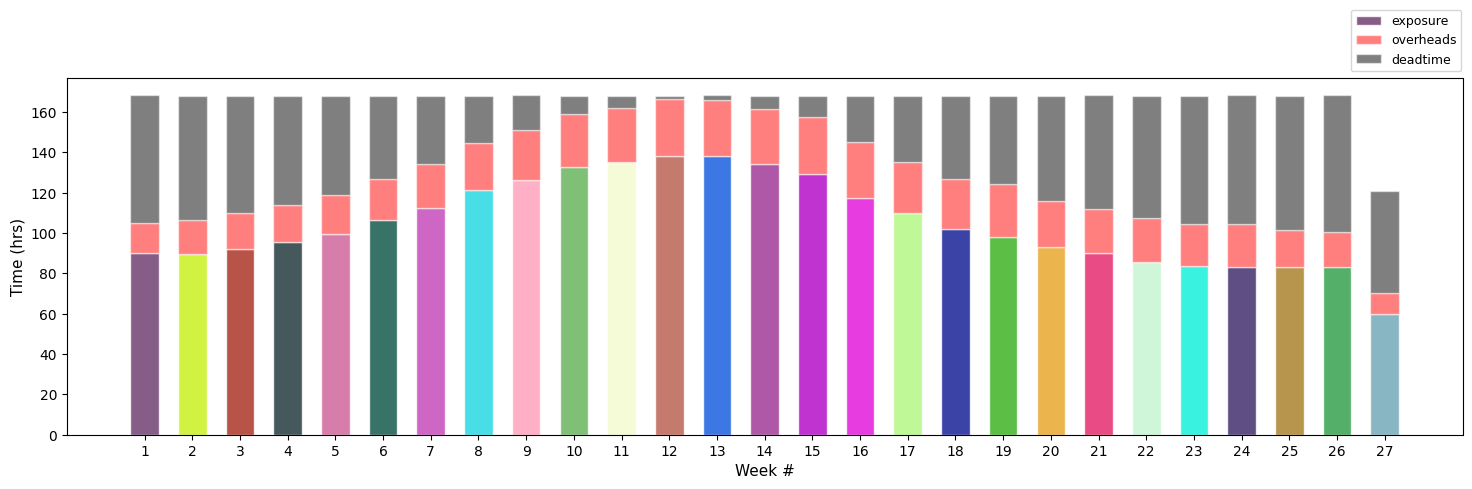

In [218]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 5))
Week = []
for i in week.keys():
    Week.append(f'{i}')

open_hr = np.array(open_per_week)/3600
overhead_hr = np.array(overhead_per_week)/3600
dead_hr = np.array(dead_per_week)/3600

bars1 = plt.bar(Week, open_hr, width=0.6, alpha=0.8, edgecolor='white', label='exposure')
bars2 = plt.bar(Week, overhead_hr, bottom=open_hr, width=0.6, alpha=0.5, color='r', edgecolor='white', label='overheads')
bars3 = plt.bar(Week, dead_hr, width=0.6, bottom=open_hr+overhead_hr, alpha=0.5, color='k', edgecolor='white', label='deadtime')

for n, color in enumerate(color_scheme):
    bars1[n].set_color(color)
    bars1[n].set_edgecolor('white')
plt.xlabel('Week #', fontsize=11)
plt.ylabel('Time (hrs)', fontsize=11)
plt.legend(fontsize=9, loc=(0.92, 1.02))
fig.tight_layout()
# plt.savefig('Weekly Time Usage.pdf')

#### Plot: Survey Tiles Colored by Week

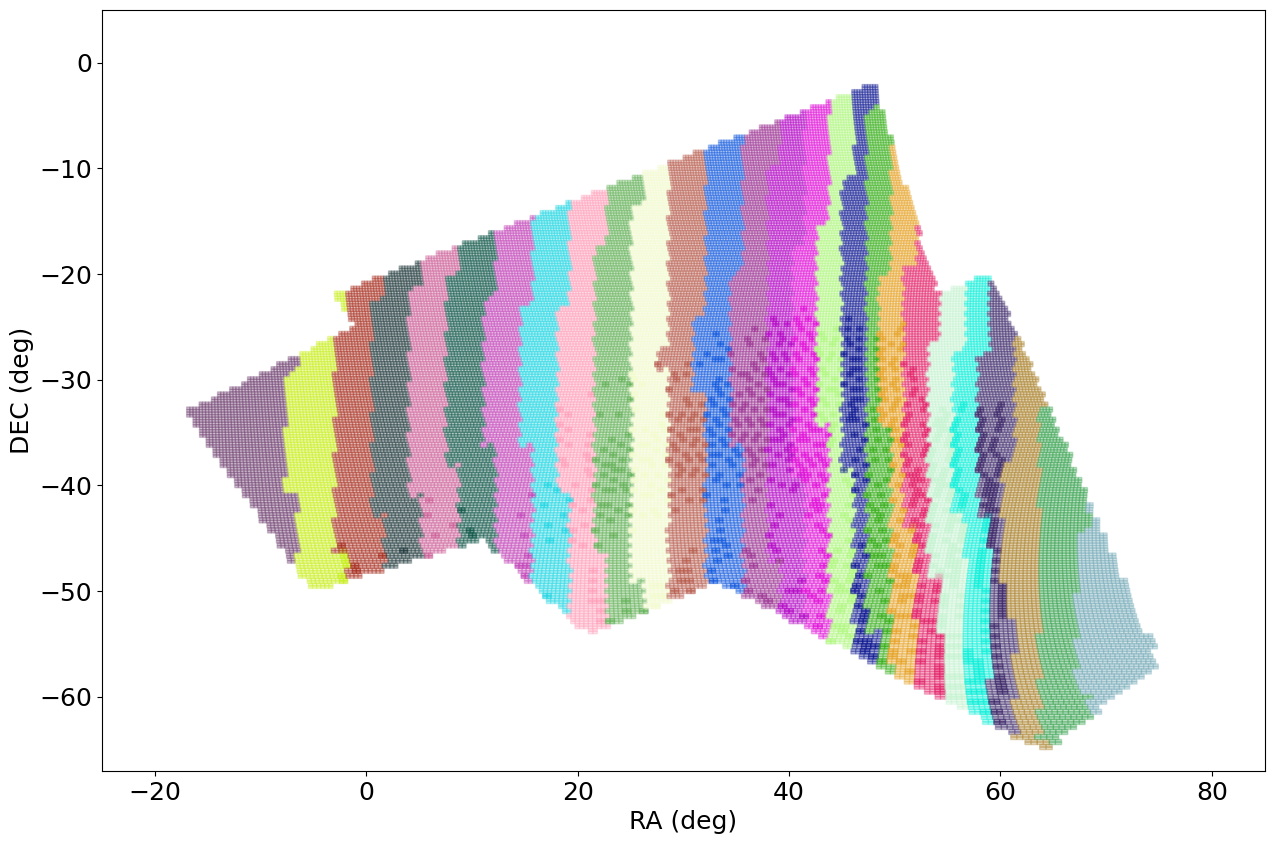

In [219]:
import numpy as np 
import matplotlib.pyplot as plt

def PlotTile(center_coords, colors):
    RA, DEC = center_coords[0], center_coords[1]
    tile = CCD_array()
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(0), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        ax.fill(ra, dec, alpha=0.3, color=colors, ec=colors)

def Circle(cx, cy, r, num=50):
    increment = 2*np.pi / num
    boundary = []
    for i in range(num):
        angle = i * increment
        x = cx + r * np.cos(angle)
        y = cy + r * np.sin(angle)
        boundary.append((x, y))
    boundary.append(boundary[0])
    return np.array(boundary)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.axis([-25, 85, -67, 5])
ax.set_aspect(1)

# Viewing Zones
earthLimbAngle = 62.7 # deg
earthExclAngle = 10 # deg
cvzHalfAngle = 90 - earthLimbAngle - earthExclAngle # deg
vis90 = AngleFromCVZ(0.9)
vis80 = AngleFromCVZ(0.8)
vis70 = AngleFromCVZ(0.7)
orbitInc = -8 # deg
uplim100, lolim100 = orbitInc+cvzHalfAngle, orbitInc-cvzHalfAngle
uplim90, lolim90 = orbitInc+vis90, orbitInc-vis90
uplim80, lolim80 = orbitInc+vis80, orbitInc-vis80
uplim70, lolim70 = orbitInc+vis70, orbitInc-vis70
# ax.plot(Circle(40, orbitInc, r=cvzHalfAngle)[:,0], Circle(40, orbitInc, r=cvzHalfAngle)[:,1], 
#         color='black', linestyle='--')
cmap = plt.colormaps["Pastel1"]
# ax.axhspan(lolim100, uplim100, facecolor='lemonchiffon', label='Continuous Viewing Zone (CVZ)')
# ax.axhspan(lolim90, lolim100, facecolor=cmap([3]), label='90% viewing zone')
# ax.axhspan(uplim100, uplim90, facecolor=cmap([3]))
# ax.axhspan(lolim80, lolim90, facecolor=cmap([2]), label='80% viewing zone')
# ax.axhspan(uplim90, uplim80, facecolor=cmap([2]))
# ax.axhspan(lolim70, lolim80, facecolor=cmap([7]), label='70% viewing zone')
# ax.axhspan(uplim80, uplim70, facecolor=cmap([7]))

# Tiles
for colors, values in zip(color_scheme, week.values()):
    # Every week
    for center in values:
        PlotTile(center, colors)
ax.set_xlabel('RA (deg)', fontsize=18)
ax.set_ylabel('DEC (deg)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
# plt.savefig('weekly tiles.pdf')

#### Plot: Time Spent per Bin

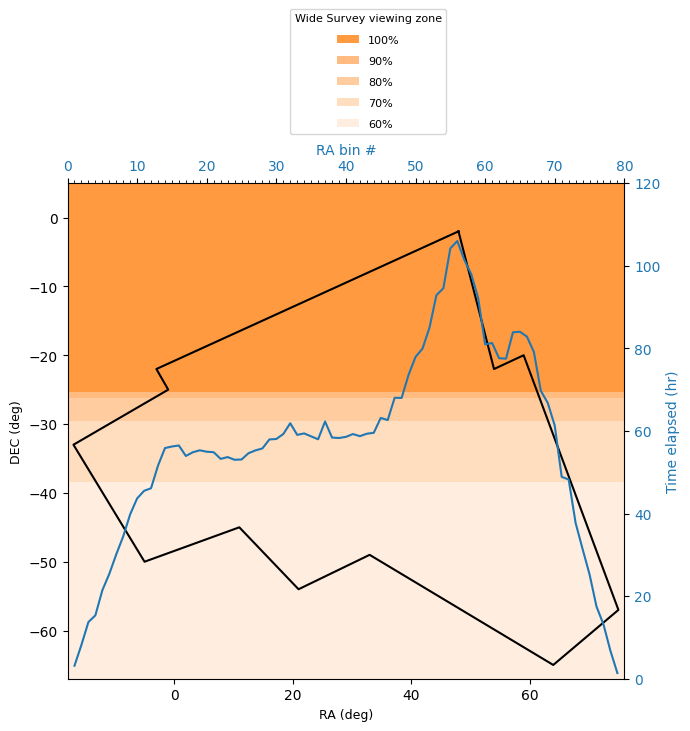

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.interpolate import interp1d

def AngleFromCVZ(viewfrac):
    AngFromCVZ = np.genfromtxt('Viewing Time.csv', delimiter=',', skip_header=1, usecols=0)
    ViewFrac = np.genfromtxt('Viewing Time.csv', delimiter=',', skip_header=1, usecols=4)
    interp = interp1d(ViewFrac, AngFromCVZ, kind='linear')
    return float(interp(viewfrac))

fig = plt.figure(figsize=(7,7.5))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frame_on=False)

# Wide Survey
Wide = np.loadtxt('Wide.txt', skiprows=1) 
footprint = Polygon(Wide)
xmin, ymin, xmax, ymax = footprint.bounds
ax1.plot(Wide[:,0], Wide[:,1], color='black')
ax1.axis([xmin-1, xmax+1, -67, 5])

# Viewing Zones
earthLimbAngle = 62.7 # deg
earthExclAngle = 10 # deg
cvzHalfAngle = 90 - earthLimbAngle - earthExclAngle # deg
vis90 = AngleFromCVZ(0.9)
vis80 = AngleFromCVZ(0.8)
vis70 = AngleFromCVZ(0.7)
vis60 = AngleFromCVZ(0.6)
orbitInc = -8 # deg
uplim100, lolim100 = orbitInc+cvzHalfAngle, orbitInc-cvzHalfAngle
uplim90, lolim90 = orbitInc+vis90, orbitInc-vis90
uplim80, lolim80 = orbitInc+vis80, orbitInc-vis80
uplim70, lolim70 = orbitInc+vis70, orbitInc-vis70
uplim60, lolim60 = orbitInc+vis60, orbitInc-vis60
ax1.axhspan(lolim100, uplim100, facecolor='#FF9A40', label='100%')
ax1.axhspan(lolim90, lolim100, facecolor='#FFBB80', label='90%')
ax1.axhspan(uplim100, uplim90, facecolor='#FFBB80')
ax1.axhspan(lolim80, lolim90, facecolor='#FFCC9F', label='80%')
ax1.axhspan(uplim90, uplim80, facecolor='#FFCC9F')
ax1.axhspan(lolim70, lolim80, facecolor='#FFDDBF', label='70%')
ax1.axhspan(uplim80, uplim70, facecolor='#FFDDBF')
ax1.axhspan(lolim60, lolim70, facecolor='#FFEEDF', label='60%')
ax1.axhspan(uplim70, uplim60, facecolor='#FFEEDF')
ax1.set_xlabel('RA (deg)', fontsize=9)
ax1.set_ylabel('DEC (deg)', fontsize=9)
ax1.legend(title='Wide Survey viewing zone', loc=(0.4, 1.1), title_fontsize=8, labelspacing=1, fontsize=8)


binindex = np.arange(1,80)
color = 'tab:blue'
ax2.axis([0, 80, 0, 120])
ax2.plot(binindex, np.array(time_per_bin)/3600, color=color)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('RA bin #', color=color)
ax2.set_ylabel('Time elapsed (hr)', color=color)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.xaxis.set_major_locator(MultipleLocator(10))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(axis='x', labelcolor=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
# plt.savefig('timeperbin.pdf')

### Organize Dead Time

In [6]:
# a continuous deadtime with telescope position range
deadtime = []

# a list of remaining time at the end of a viewing cycle that is above 200s 
# with telescope position range
remain_deadtime = []

merge = 0 # indicator
for i in range(len(place_holder)-1):
    # if there is merge_time previously, skip this iteration
    if merge != 0:
        merge = 0 # reset
        continue
    current_start = place_holder[i][1][0]
    current_end = place_holder[i][1][1]
    next_start = place_holder[i+1][1][0]
    next_end = place_holder[i+1][1][1]
    if round(current_end,2) == round(next_start,2):
        merge_time = place_holder[i][0] + place_holder[i+1][0]
        merge_range = [current_start, next_end]
        deadtime.append([merge_time, merge_range])
        merge = 1
        short_deadtime = place_holder[i][0]
        if short_deadtime > 200:
            remain_deadtime.append(place_holder[i])
    else:
        deadtime.append(place_holder[i])
        
len(remain_deadtime)

7

In [13]:
time_only = []
for i in deadtime:
    time = i[0]
    time_only.append(time)
np.mean(time_only)/60

30.181004290604125

### Animation

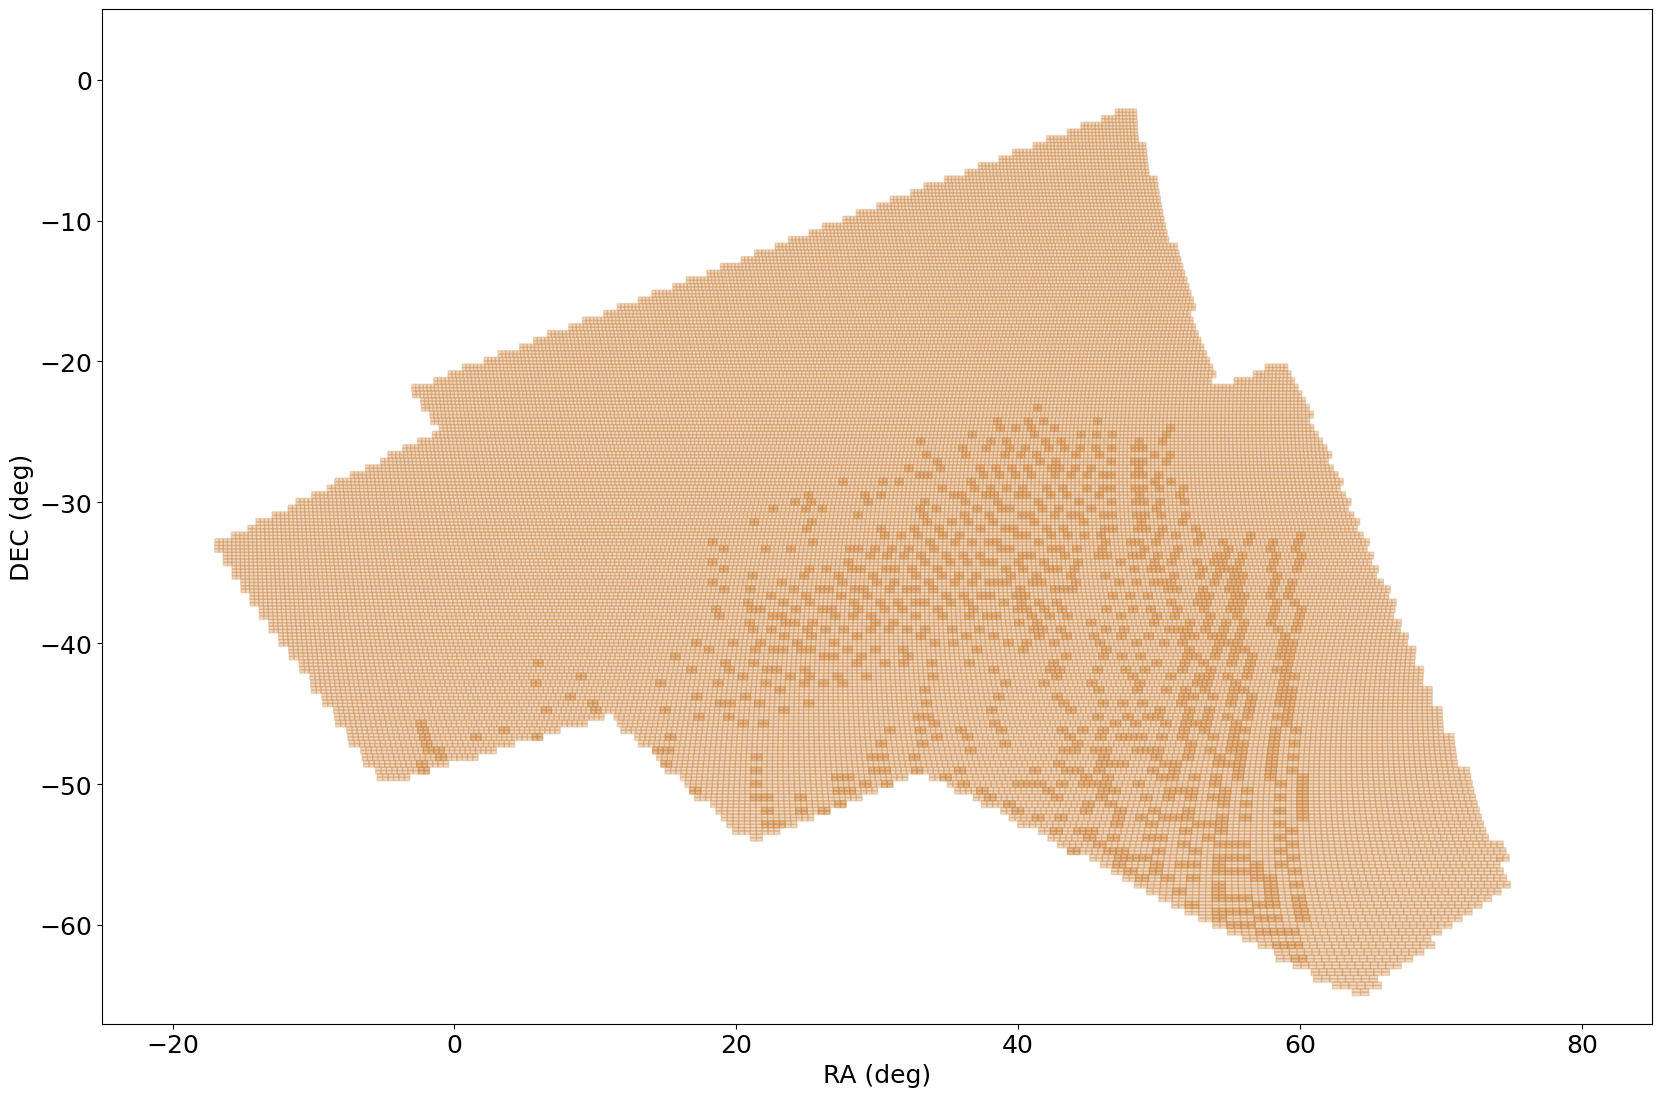

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

def PlotTile(center_coords, colors):
    RA, DEC = center_coords[0], center_coords[1]
    tile = CCD_array()
    for CCD in tile:
        ra = []
        dec = []
        for i in range(4):
            # CCD[i] = (x, y, z) of each vertex of the CCD 
            CCD[i] = np.matmul(rotate(0), CCD[i])
            CCD[i] = np.matmul(move(RA, DEC), CCD[i])
            x, y, z = CCD[i][0], CCD[i][1], CCD[i][2]
            # cartesian to equatorial 
            ra.append(np.rad2deg(math.atan2(y,x)))
            dec.append(np.rad2deg(math.asin(z)))
        ra.append(ra[0])
        dec.append(dec[0])
        ax.fill(ra, dec, alpha=0.3, color=colors, ec=colors)

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
ax.axis([-25, 85, -67, 5])
ax.set_aspect(1)
ax.set_xlabel('RA (deg)', fontsize=18)
ax.set_ylabel('DEC (deg)', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# Initialize an empty plot for the tiles
tiles_plot = ax.fill([], [], alpha=0.2, color='peru', ec='peru')

def init():
    return tiles_plot

def animate(i):
    tiles_per_frame = 10  # Number of tiles to plot per frame
    start_index = i * tiles_per_frame
    end_index = min((i + 1) * tiles_per_frame, len(tile_sequence))

    for j in range(start_index, end_index):
        center = tile_sequence[j]
        PlotTile(center, 'peru')
        # Update the plot with the newly added tile's vertices
        tiles_plot[0].set_xy(plt.gca().patches[-1].get_xy())

# Calculate the number of frames based on the number of tiles and tiles per frame
num_tiles = len(tile_sequence)
tiles_per_frame = 10
num_frames = (num_tiles + tiles_per_frame - 1) // tiles_per_frame

# Use the animation function to update the plot frame by frame
ani = FuncAnimation(fig, animate, init_func=init, frames=num_frames, interval=1)
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
writergif = matplotlib.animation.PillowWriter(fps=30) 
ani.save('tiling.gif', writer=writergif)
